[i 1228 03:19:17.128391 00 log.cc:351] Load log_sync: 1
[i 1228 03:19:17.221532 00 compiler.py:956] Jittor(1.3.8.5) src: /Users/johonnycake/anaconda3/envs/completion/lib/python3.10/site-packages/jittor
[i 1228 03:19:17.280326 00 compiler.py:957] clang at /usr/bin/clang++(15.0.0)
[i 1228 03:19:17.282192 00 compiler.py:958] cache_path: /Users/johonnycake/.cache/jittor/jt1.3.8/clang15.0.0/py3.10.13/macOS-10.16-x8x71/IntelRCoreTMi7xa6/default
[i 1228 03:19:17.884332 00 __init__.py:232] using 4 procs for compiling.
[i 1228 03:19:18.163228 00 jit_compiler.cc:28] Load cc_path: /usr/bin/clang++
/Users/johonnycake/anaconda3/bin/mpicc: line 285: x86_64-apple-darwin13.4.0-clang: command not found


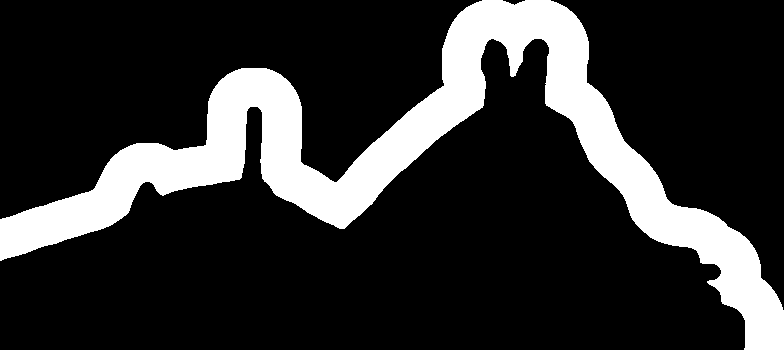

In [1]:
import jittor as jt
from jittor import nn

from PIL import Image
from tqdm import tqdm
import cv2
import numpy as np
import pickle
from func import *

cur_task = '1'

im = np.array(Image.open(f'../data/inputs/input{cur_task}.jpg'))
mask = Image.open(f'../data/inputs/input{cur_task}_mask.jpg')
patch = np.array(Image.open(f'../data/inputs/input{cur_task}_patch.jpg')).astype(np.int64)

# binarize mask
thresh = 128
binary_mask = mask.point(lambda p: p > thresh and 255)

# use curcular kernel to erode the mask
radius = 80
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (radius, radius))
eroded_mask = cv2.erode(np.array(binary_mask),kernel,iterations = 1)

# get the cropped_window
diff = np.array(binary_mask) - eroded_mask # white part is part we should calculate
window = np.array(Image.fromarray(diff).convert('1'))

# apply the cropped_window to the image
masked_im = im * window[:,:,None]

# get the bounding rect
eroded_mask = 255 - eroded_mask
top_bound, bottom_bound, left_bound, right_bound = get_bounding_rect(eroded_mask)
cropped_window = window[top_bound:bottom_bound, left_bound:right_bound]
cropped_im = masked_im[top_bound:bottom_bound, left_bound:right_bound, :]

display(Image.fromarray(cropped_window))

In [6]:
# it costs around 50 seconds to calculate the cross items(*.ipynb runs slower than *.py)

# use correlation to calculate the cross items
# with jittor
patch_jt = jt.array([patch]).transpose(0,3,1,2).astype(np.int64)
cropped_im_jt = jt.array([cropped_im]).transpose(0,3,1,2).astype(np.int64)
cross_items = nn.conv2d(patch_jt, cropped_im_jt, padding=0, stride=1)
cross_items = cross_items[0].data
cross_items = cross_items.reshape(cross_items.shape[1], cross_items.shape[2])

print("cross_items:", cross_items.shape)

# save with pickle
with open(f'../data/pickles/{cur_task}/cross_items.pkl', 'wb') as f:
    pickle.dump(cross_items, f)

cross_items: (419, 241)


In [7]:
# it costs around 50 seconds to calculate the square items(*.ipynb runs slower than *.py)

# use correlation to calculate the masked square items
# with jittor
window_jt = jt.array([[cropped_window.astype(np.int64)]]).repeat((3,1,1,1)).transpose(1,0,2,3).astype(np.int64)
patch_square_jt = patch_jt * patch_jt
square_items = nn.conv2d(patch_square_jt, window_jt, padding=0, stride=1)
square_items = square_items[0].data
square_items = square_items.reshape(square_items.shape[1], square_items.shape[2])

print("square_items:", square_items.shape)

# save with pickle
with open(f'../data/pickles/{cur_task}/square_items.pkl', 'wb') as f:
    pickle.dump(square_items, f)

square_items: (419, 241)


100%|██████████| 418/418 [00:00<00:00, 4475.23it/s]

146934471


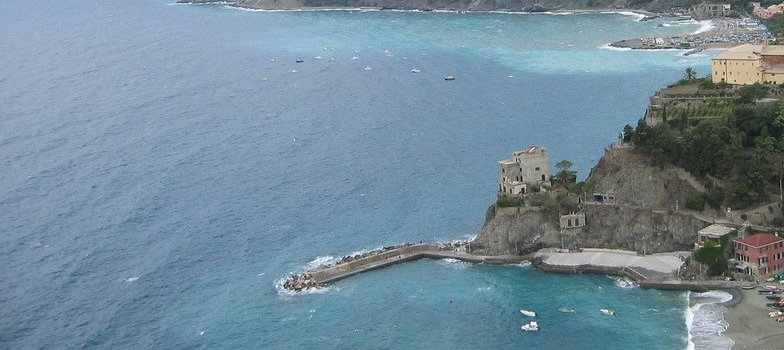

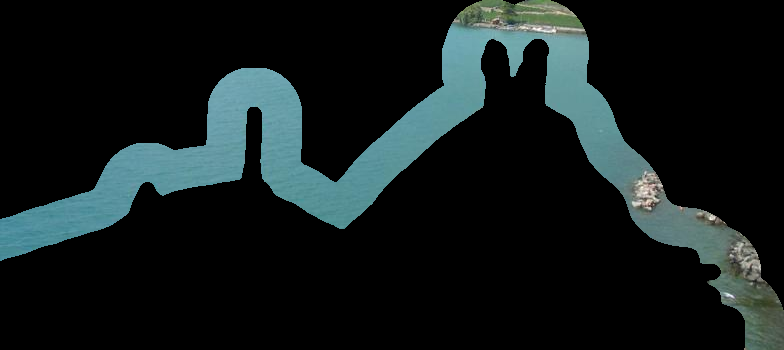

In [3]:
# load from pickle
with open(f'../data/pickles/{cur_task}/cross_items.pkl', 'rb') as f:
    cross_items = pickle.load(f)
with open(f'../data/pickles/{cur_task}/square_items.pkl', 'rb') as f:
    square_items = pickle.load(f)

square_sum_cropped_im = np.sum(cropped_im.astype(np.int64) ** 2)

min_l2_loss = 1e18
best_patch = None

for x in tqdm(range(patch.shape[0] - cropped_window.shape[0])):
    for y in range(patch.shape[1] - cropped_window.shape[1]):
        
        l2_loss = \
            square_sum_cropped_im \
                + square_items[x, y] \
                    - 2 * cross_items[x, y]
        
        if l2_loss < min_l2_loss:
            min_l2_loss = l2_loss
            best_patch_coord = (x, y)

print(min_l2_loss)
best_patch = patch[best_patch_coord[0]:best_patch_coord[0]+cropped_window.shape[0], best_patch_coord[1]:best_patch_coord[1]+cropped_window.shape[1], :].astype(np.uint8)
display(Image.fromarray(best_patch.astype(np.uint8)))
display(Image.fromarray(cropped_im.astype(np.uint8)))

[[0 0 1 0 0]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [0 0 1 0 0]]


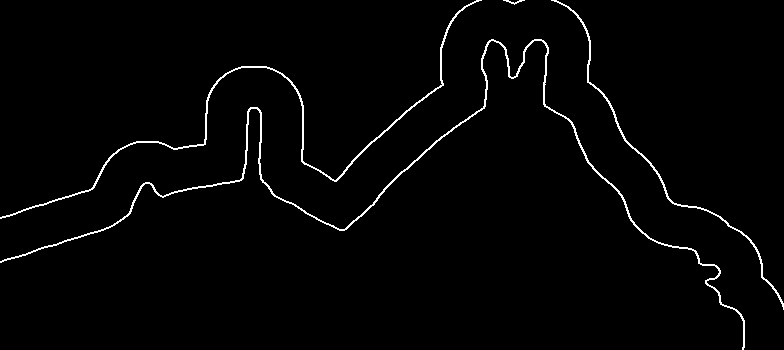

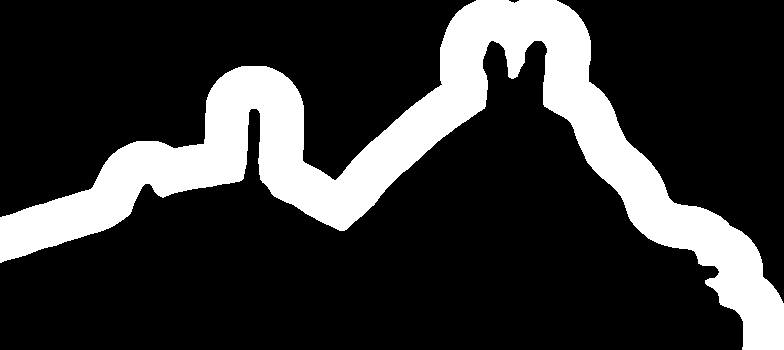

In [4]:
# prepare for running Edmonds-Karp algorithm

cropped_im = im[top_bound:bottom_bound, left_bound:right_bound, :]
cropped_mask = True ^ np.array(binary_mask.convert('1'))[top_bound:bottom_bound, left_bound:right_bound] # True part is to patch

node_count = cropped_window.shape[0] * cropped_window.shape[1] + 2
inf_weight = 100000.0 # pick a large enough number

source = 0
sink = 1

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
print(kernel)
dilated_window = cv2.dilate(np.array(cropped_window).astype(np.uint8),kernel,iterations = 1)
node_count = np.sum(dilated_window > 0) + 2

n_indices = [-1] * cropped_window.shape[1]
n_indices = [n_indices.copy() for _ in range(cropped_window.shape[0])]

n_index = 2

for i in range(cropped_window.shape[0]):
    for j in range(cropped_window.shape[1]):
        if dilated_window[i, j]:
            n_indices[i][j] = n_index
            n_index += 1
assert n_index == node_count

boundary = dilated_window - cropped_window # -1 
display(Image.fromarray(boundary * 255))
display(Image.fromarray(dilated_window * 255))

# run graph cut on gradient domain
best_patch_gradient = np.gradient(best_patch.astype(np.float64), axis=(0, 1))
best_patch_gradient = np.array(best_patch_gradient).transpose(1, 2, 3, 0)

cropped_im_gradient = np.gradient(cropped_im.astype(np.float64), axis=(0, 1))
cropped_im_gradient = np.array(cropped_im_gradient).transpose(1, 2, 3, 0)

In [6]:

# it's extremely slow(*.ipynb runs slower than *.py)
# time-consuming though, the result is consistent with the version using maxflow package
# the result is saved in the file "pickles/graph.pkl", you can load it directly

# please refer to `mymaxflow.py` for the implementation of Edmonds-Karp algorithm
from mymaxflow import Graph
graph = Graph(node_count)

inf_weight = 100000.0 # pick a large enough number

for i in range(cropped_window.shape[0]):
    for j in range(cropped_window.shape[1]):
        if dilated_window[i, j]:
            if boundary[i, j]:
                if cropped_mask[i, j]:
                    graph.add(source, n_indices[i][j], inf_weight, 0) # if patch, connect to sink
                elif not cropped_window[i, j]:
                    graph.add(n_indices[i][j], sink, inf_weight, 0) # if not patch, connect to source
                else:
                    assert False

            if i + 1 < cropped_window.shape[0]:
                if cropped_window[i, j] and cropped_window[i+1, j]:
                    weight = np.linalg.norm((best_patch_gradient[i, j] - cropped_im_gradient[i, j]).astype(np.float64)) \
                                + np.linalg.norm((best_patch_gradient[i+1, j] - cropped_im_gradient[i+1, j]).astype(np.float64))
                    graph.add(n_indices[i][j], n_indices[i+1][j], weight, weight)
                elif dilated_window[i+1, j]:
                    graph.add(n_indices[i][j], n_indices[i+1][j], inf_weight, inf_weight)
            
            if j + 1 < cropped_window.shape[1]:
                if cropped_window[i, j] and cropped_window[i, j+1]:
                    weight = np.linalg.norm((best_patch_gradient[i, j] - cropped_im_gradient[i, j]).astype(np.float64)) \
                                + np.linalg.norm((best_patch_gradient[i, j+1] - cropped_im_gradient[i, j+1]).astype(np.float64))
                    graph.add(n_indices[i][j], n_indices[i][j+1], weight, weight)
                elif dilated_window[i, j+1]:
                    graph.add(n_indices[i][j], n_indices[i][j+1], inf_weight, inf_weight)

flow = graph.maxflow(source, sink)
print("flow:", flow)

with open(f'../data/pickles/{cur_task}/graph.pkl', 'wb') as f:
    pickle.dump(graph, f)


update the 1th time, push = 6.690393165058025, flow = 0
update the 2th time, push = 7.9581964079674865, flow = 6.690393165058025
update the 3th time, push = 6.045794588873761, flow = 14.648589573025511
update the 4th time, push = 4.773432072717987, flow = 20.694384161899272
update the 5th time, push = 4.152826349898926, flow = 25.46781623461726
update the 6th time, push = 6.244997998398398, flow = 29.620642584516187
update the 7th time, push = 2.449489742783178, flow = 35.86564058291459
update the 8th time, push = 2.956795678960466, flow = 38.315130325697766
update the 9th time, push = 3.6685424806725857, flow = 41.27192600465823
update the 10th time, push = 5.023158826703222, flow = 44.94046848533082
update the 11th time, push = 3.9240959812916367, flow = 49.96362731203404
update the 12th time, push = 3.872983346207417, flow = 53.88772329332568
update the 13th time, push = 4.347243870590788, flow = 57.7607066395331
update the 14th time, push = 3.9633576589174195, flow = 62.10795051012

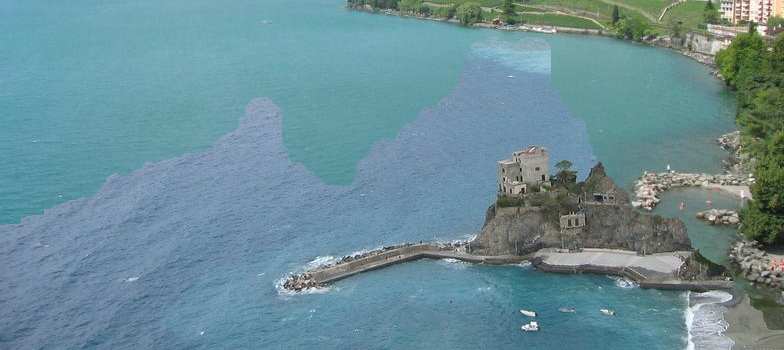

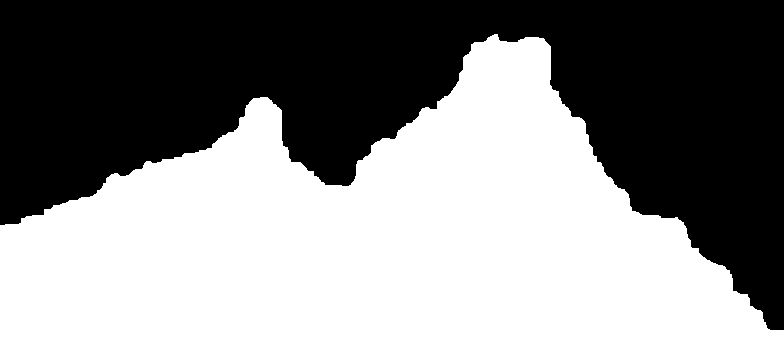

In [5]:
# load from pickle
with open(f'../data/pickles/{cur_task}/graph.pkl', 'rb') as f:
    graph = pickle.load(f)

graph.mark_affiliation(source)

patched_im = np.zeros_like(cropped_im).astype(np.uint8)
pasted_im = cropped_im.copy()
seam_mask = np.zeros_like(cropped_im).astype(np.uint8)

for i in range(cropped_window.shape[0]):
    for j in range(cropped_window.shape[1]):
        if not cropped_window[i, j] and not cropped_mask[i, j]:
            # continue
            patched_im[i, j] = cropped_im[i, j]
        elif cropped_mask[i, j]:
            # continue
            patched_im[i, j] = best_patch[i, j]
            pasted_im[i, j] = best_patch[i, j]
            seam_mask[i, j] = 255

        else:
            if graph.aff[n_indices[i][j]] == sink:
                patched_im[i, j] = cropped_im[i, j]
            elif graph.aff[n_indices[i][j]] == source:
                patched_im[i, j] = best_patch[i, j]
                seam_mask[i, j] = 255
            else:
                # unreachable
                assert False

display(Image.fromarray(patched_im.astype(np.uint8)))
display(Image.fromarray(seam_mask.astype(np.uint8)))

In [6]:
# implement poisson blending

fg = best_patch.astype(np.float64)/255
bg = pasted_im.astype(np.float64)/255
mask = (seam_mask[:,:,0] > 0)

# please refer to `blending.py` for the implementation of `buildSystemSparse`, `computeb` and `Jacobi_iteration`
from blending import *

A, indices = buildSystemSparse(fg[:,:,0].shape,mask)
A_csr = A.tocsr()
b = computeb(fg, bg, mask, indices)

In [9]:
# it takes around 5 minutes on my 9th gen i7 cpu(*.ipynb runs slower than *.py)
import concurrent.futures
with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
    # use 3 threads (maximum) for parallel acceleration
    futures = [executor.submit(Jacobi_iteration, A, b[:, i], 100000, 1e-6) for i in range(3)]
    x = [f.result() for f in futures]
x = np.clip(np.stack(x, axis=0).transpose(1, 0), 0, 1)

# save with pickle
with open(f'../data/pickles/{cur_task}/x.pkl', 'wb') as f:
    pickle.dump(x, f)

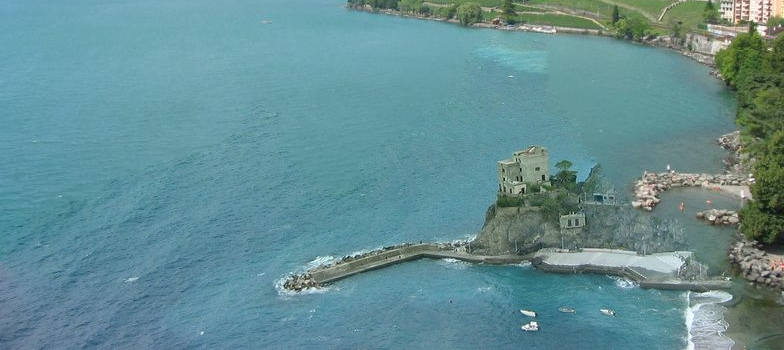

In [7]:
# load from pickle
with open(f'../data/pickles/{cur_task}/x.pkl', 'rb') as f:
    x = pickle.load(f)

for i in range(bg.shape[0]):
    for j in range(bg.shape[1]):
        if mask[i, j]:
            bg[i, j] = x[indices[i, j]]

display(Image.fromarray((bg*255).astype(np.uint8)))

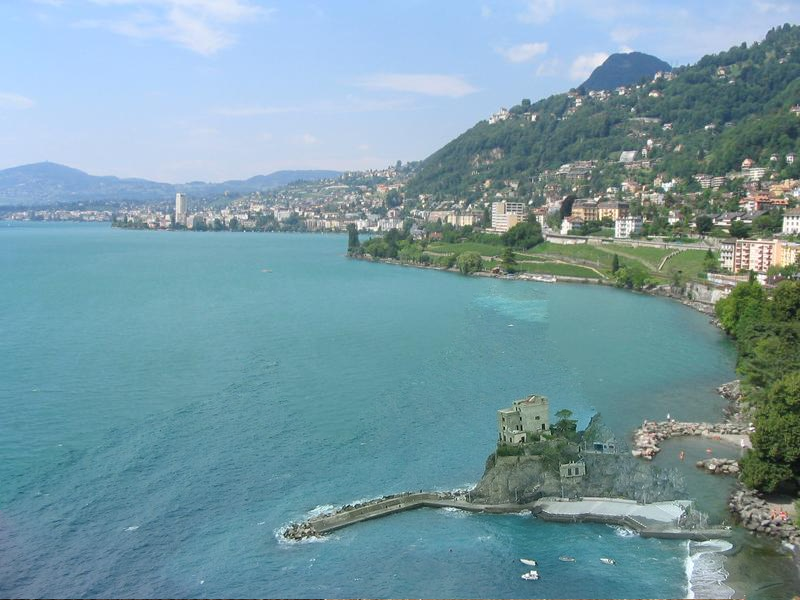

In [8]:
# put the blended image back to the original image
result = im.copy()
result[top_bound:bottom_bound, left_bound:right_bound, :] = bg * 255
display(Image.fromarray(result.astype(np.uint8)))